In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report,confusion_matrix
import torch
from abc import ABC,abstractmethod

## DATASET PREP

In [ ]:
#import data
def getAllPaths(path:str, excludeList = None):
    path = path
    pathList = []
    labelList = []
    dirList = os.listdir(path)[:3]
    for idx, x in enumerate(dirList):
        for xx in os.listdir(f"{path}/{x}"):
            pathList.append(f"{path}/{x}/{xx}")
            labelList.append(idx)
    if excludeList:
        pathList = [x for x in pathList if not any(xx in x for xx in excludeList)]
    return pathList, labelList

trainPath = r".\ExperimentSet"
valPath = r".\ValidationSet"
originalPath = r".\Osteoporosis Knee X-ray"

excludeList = ['Rp','Rn','Sup','Sdown','Sleft','Sright']

trainPathList,trainLabelList = getAllPaths(trainPath)
# trainPathList,trainLabelList = getAllPaths(trainPath,excludeList)
valPathList,valLabelList = getAllPaths(valPath)
originalPathList,originalLabelList = getAllPaths(originalPath)

trainDirList = os.listdir(trainPath)[:3]
valDirList = os.listdir(valPath)[:3]
print(trainPathList[:5])

In [ ]:
#check val distribution (this should be 10,10,10)
#this does not account for excluded names
trainDist = []
for idx,x in enumerate(valDirList):
    print(f"val {x}: {len(os.listdir(f'{valPath}/{x}'))}")

for idx,x in enumerate(trainDirList):
    print(f"train {x}: {len(os.listdir(f'{trainPath}/{x}'))}")
    
    trainDist.append(len(os.listdir(f'{trainPath}/{x}')))

In [ ]:
#check image sizes
from PIL import Image
imageSizes = {}
for x in trainPathList:
    img = Image.open(x).size
    try:
        imageSizes[str(img)] = imageSizes[str(img)] + 1
    except KeyError:
        imageSizes[str(img)] = 1
imageSizes #varied image sizes, have to resize to 1024,1024

In [ ]:
import torchvision
import torch
import torchvision.transforms.functional as vF

class OsteoTorchDataset(torch.utils.data.Dataset):
    def __init__(self, itemsPath:list, labels:list, transform=None): 
        
        self.itemsPath = itemsPath
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.itemsPath)

    def __getitem__(self,idx):
        image = Image.open(self.itemsPath[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)  
        
        image.to(device = torch.device('cuda'))

        return image, self.labels[idx], self.itemsPath[idx]          
    
transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.RandomResizedCrop((224,224),scale=(0.666,1.0)),
                                            # torchvision.transforms.Resize((224,224)),
                                            # torchvision.transforms.CenterCrop((224,224)),
                                            # torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                            ])                           
valTransform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            # torchvision.transforms.Resize((224,224)),
                                            # torchvision.transforms.RandomHorizontalFlip(p=1),
                                            torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                            ])                           

In [ ]:
# # Code to save Processed images to disk to save on processing time
# import PIL
# trainDataset = OsteoTorchDataset(trainPathList,trainLabelList,transform)
# for x in trainDataset:
#     arr = ((x[0].permute(1,2,0)*255).numpy().astype(np.uint8))
#     img = PIL.Image.fromarray(arr,mode="RGB")
#     img.save(x[2])

In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import WeightedRandomSampler

#inits dataset and dataloader + resamples training data to balance classes
trainDataset = OsteoTorchDataset(trainPathList,trainLabelList,transform)      
valDataset = OsteoTorchDataset(valPathList,valLabelList,valTransform)

unique_elements, counts = torch.unique(torch.tensor(trainLabelList), return_counts=True)
sampleWeights = 1. / counts.float() #I HAVE NO IDEA WHY THIS WORKS BUT IT DOES
# MORAL OF THE STORY: FOLLOW THE FUCKING TUTORIAL DONT TRY CHANGING SHIT ON YOUR OWN ***EVEN IF THE DOCUMENTATION SAYS YOU SHOULD***
# trainSampler = WeightedRandomSampler(weights=[sampleWeights[x] for x in trainLabelList],num_samples=len(trainDataset),replacement=True)

trainSampler = WeightedRandomSampler(weights=[sampleWeights[x] for x in trainLabelList],num_samples=min(trainDist)*3,replacement=True)

trainLoader = DataLoader(trainDataset, batch_size = 8,shuffle=False,num_workers=0,sampler=trainSampler)
valLoader = DataLoader(valDataset, batch_size = 8,shuffle=False,num_workers=0)

unique_elements, counts = torch.unique(torch.cat([x for y,x,z in trainLoader]), return_counts=True)#delete this
counts

In [ ]:
unique_elements, counts = torch.unique(torch.cat([x for y,x,z in valLoader]), return_counts=True)#delete this
counts

In [ ]:
temp = next(iter(trainLoader))
index = -1

temp[0][0].max()

In [ ]:
# temp[0][0].min()

import matplotlib.pyplot as plt
index += 1
# print(temp[1][index],temp[2][index])
print((temp[0][index].numpy()*255).max().astype(np.uint8))

fig, axs = plt.subplots(1, 2)

print(str(temp[2][index]))
# Plot the first image
axs[0].imshow(((temp[0][index]+1)/2).permute(1, 2, 0))
axs[0].set_title('Image 1')

# Plot the second image
axs[1].imshow(Image.open(temp[2][index]).convert('RGB'))
axs[1].set_title('Image 2')

plt.show()

## MODEL PREP


In [ ]:
# import models here
import sklearn.metrics
from resnetModel import ResNet50
import sklearn
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torcheval.metrics.functional import multiclass_f1_score,multiclass_confusion_matrix,multiclass_accuracy
from torchmetrics.classification import MulticlassConfusionMatrix
from matplotlib import pyplot as plt
import cv2
from torch import mode
import torch.nn.functional as F
import itertools
import seaborn as sns
from abc import ABC

#FIXME clean up my fucking code ffs its so UGLY

class ExperimentModel(L.LightningModule,ABC):

    existingModels = []

    def __init__(self) -> None:
        ExperimentModel.existingModels.append(self)
        super().__init__()

        #init the models here in a subclass
        self.imbalanceWeight = 0
        self.num_class = 3
        self.classWeight = torch.tensor([0.204, 0.052, 0.175],device='cuda')*self.imbalanceWeight
        
        if (torch.tensor([0.204, 0.052, 0.175],device='cuda')*0).detach()[0].item() == 0:
            self.classWeight = torch.ones(self.classWeight.size(),device='cuda')

        self.dump = []

    @abstractmethod
    def forward():
        pass
    
    def training_step(self,batch):
        data,label,path = batch
        output = self(data)
        self.dump.append([path,label])
        loss = F.cross_entropy(output,label,weight=self.classWeight)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", multiclass_accuracy(output.argmax(1),label,num_classes=self.num_class), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx) -> None:
        data,label,path = batch
        output = self(data)

        preds = output.argmax(1)
        loss = F.cross_entropy(output,label)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_F1", sklearn.metrics.f1_score(label.cpu(),preds.cpu(),labels = range(self.num_class),average = 'macro',zero_division=1), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", multiclass_accuracy(preds,label,num_classes=self.num_class), on_step=False, on_epoch=True, prog_bar=True, logger=True)

    
    # def on_validation_epoch_end(self) -> None:

    #     accuracy = torch.stack(self.valScore).mean()
    #     self.bestValScore.append(accuracy)
    #     self.bestValPreds.append(torch.cat(self.valPreds))
    #     self.bestValLabels.append(torch.cat(self.valLabels))
        # self.log("val_acc_F1", multiclass_f1_score(torch.cat(self.valPreds),torch.cat(self.valLabels),num_classes=self.num_class,average = 'macro'), on_step=False, on_epoch=True, prog_bar=True, logger=True)
       

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        return optimizer

    def predict_step(self, batch):
        data,label = batch
        return self(data.float())

In [ ]:
import functools
import re
import resnetModel
import shutil

class GradCamTrack(ExperimentModel): #Class for GradCam visualization, should be subclassed by the model to be visualized with a new init and a forward + hook
    
    def __init__(self,) -> None:
        super().__init__()
        
        self.gradients = None
        self.cachedActivation = None

    # cachedActivation is no longer needed, but kept for legacy purposes
    def activations_hook(self, grad, imageActivation = None):
        if imageActivation != None:
            self.cachedActivation = imageActivation
        self.gradients = grad

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)
     
    # Runs CAM and overlays the image
    # this is the function to call for visualization
    def visualize(self,dataloader:torch.utils.data.dataloader.DataLoader): #TODO FIX THIS for generalization
        with torch.inference_mode(False):
            out,path,pred = self.CAM(dataloader)
        try:
            os.mkdir(rf'./visualizations/gradCam/{self.__class__.__name__}/')
        except:
            pass
        try:
            shutil.rmtree(rf'./visualizations/gradCam/{self.__class__.__name__}/{self.current_epoch}')
        except FileNotFoundError:
            pass
        
        os.mkdir(rf'./visualizations/gradCam/{self.__class__.__name__}/{self.current_epoch}')
        for i in range(len(out)):
            
            self.visualizeAndWrite(out[i],path[i],pred[i])
        return pred,path
    
    # Visualizes the Gradients of the last conv layer of model
    # can take in torch dataloader or ([img],[label],[path])
    def CAM(self,dataloader:torch.utils.data.dataloader.DataLoader):
        
        self.eval()
        self.requires_grad_()
        predList = []

        pathList = []
        
        heatmapList = []

        for x in dataloader:
            img,label,path = x

            img = img.to(device = torch.device('cuda'))
            for i in range(len(img)):
                out = self(torch.unsqueeze(img[i],0).requires_grad_())
                pred= out.argmax(1).item()
                predList.append(pred)
                # get the gradient of the output with respect to the parameters of the model
                out[:, pred].backward()

                # pull the gradients out of the model
                gradients = self.get_activations_gradient()

                # pool the gradients across the channels
                pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

                # get the activations of the last convolutional layer
                if self.cachedActivation != None:
                    activations = self.cachedActivation.detach()
                else:
                    activations = self.get_activations(torch.unsqueeze(img[i],0)).detach() # DONT forget to apply image changes here too
                # weight the channels by corresponding gradients
                for j in range(pooled_gradients.shape[0]):
                    activations[:, j, :, :] *= pooled_gradients[j]
                    
                # average the channels of the activations
                heatmap = torch.mean(activations, dim=1).squeeze()

                # relu on top of the heatmap
                # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
                heatmap = np.maximum(heatmap.detach().cpu(), 0)

                # normalize the heatmap
                heatmap /= torch.max(heatmap)

                # draw the heatmap
                heatmapList.append(heatmap)
                
                pathList.append(path[i])

                self.zero_grad()

        return heatmapList,pathList,predList
    

    #writes files to disk for visualization, format: model_epoch_label_pred/image.jpg
    def visualizeAndWrite(self,out:torch.tensor,path:str,pred:str,epoch=False): #TODO Implement this with logger
        if not epoch:
            epoch = self.current_epoch

        labelDict = {0:'N',1:'OP',2:'OS'}
            
        img = cv2.imread(path)
        heatmap = cv2.resize(out.numpy(), (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = heatmap * 0.4 + img
        cv2.imwrite(rf'./visualizations/gradCam/{self.__class__.__name__}/{epoch}/pred{str(labelDict[pred])}_{path.split(r"/")[-1]}', superimposed_img)

    def on_validation_epoch_end(self) -> None:
        super().on_validation_epoch_end()
        pred,path = self.visualize(valLoader)
        label = [x.split(r"/")[-2] for x in path]
        labelDict = {'normal':0,'osteopenia':1,'osteoporosis':2}
        
        label = [labelDict[x] for x in label]
        # self.log("classification report",classification_report(label,pred))
        print(classification_report(label,pred,zero_division=1))
        plt.clf()
        cm= confusion_matrix(label,pred,labels=[0,1,2],normalize='true',zero_division=1)
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        # self.log({'Confusion Matrix': plt.gcf()}) #watch out for BUG


In [ ]:

class VGGModel(GradCamTrack):
    def __init__(self,vgg:torchvision.models.vgg.VGG) -> None:
        super().__init__()
        self.features_conv = vgg.features[:36]
        # get the max pool of the features stem
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = vgg.classifier
        self.classifier[6] = torch.nn.Linear(4096,self.num_class)


    def forward(self,inTensor):
        x = self.features_conv(inTensor)
        
        # # register the hook
        if x.requires_grad:
            hook = x.register_hook(self.activations_hook)
        
        x = self.max_pool(x)
        x = x.flatten(1,-1)
        x = self.classifier(x)
        return x

class ResnetModel(GradCamTrack):
    def __init__(self,resnet:torchvision.models.resnet.ResNet) -> None:
        super().__init__()
        self.features_conv = torch.nn.Sequential(*[x for x in resnet.children()][:-2])
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1,1))
        self.fc = torch.nn.Linear(2048, self.num_class)
        # self.model.layer4[2] = resnetModel.CustBottleneck(2048,512,self.activations_hook)
        # self.model.fc = torch.nn.Linear(2048,3)
        
    def forward(self,inTensor:torch.tensor):
        x = self.features_conv(inTensor)
        
        if x.requires_grad:
            hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

class InceptionModel(GradCamTrack):
    def __init__(self,inception:torchvision.models.inception) -> None:
        super().__init__()
        self.features_conv = torch.nn.Sequential(*[x for x in inception.children()][:-3])
        self.classifier = torch.nn.Sequential(*[x for x in inception.children()][-3:])
        self.classifier[-1] = torch.nn.Linear(in_features=2048, out_features=self.num_class, bias=True)
        
    def forward(self,inTensor:torch.tensor):
        x = self.features_conv(inTensor)
        
        if x.requires_grad:
            hook = x.register_hook(self.activations_hook)
        
        x = self.classifier(x)
        return x

class EfficientNetModel(GradCamTrack):
    def __init__(self,effNet:torchvision.models.efficientnet) -> None:
        super().__init__()
        self.features_conv = effNet.features
        self.avgpool = effNet.avgpool
        self.classifier = effNet.classifier
        self.classifier[1] = torch.nn.Linear(1280,self.num_class)
        
        
    def forward(self,inTensor:torch.tensor):
        x = self.features_conv(inTensor)
        
        if x.requires_grad:
            hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Model Run

In [ ]:
# Init models here

ExperimentModel.existingModels = []
# resnet50 = ResnetModel(torch.hub.load('pytorch/vision:v0.19.0', 'resnet50', pretrained=True))

vgg19 = VGGModel(torchvision.models.vgg19(pretrained=True))

# inceptionv3 = InceptionModel(torch.hub.load('pytorch/vision:v0.19.0', 'inception_v3', pretrained=True))
# efficientNetv2 = EfficientNetModel(torch.hub.load('pytorch/vision:v0.19.0', 'efficientnet_v2_l', pretrained=True))

Using 16bit Automatic Mixed Precision (AMP)


VGGModel


c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | features_conv | Sequential | 20.0 M | train
1 | max_pool      | MaxPool2d  | 0      | train
2 | classifier    | Sequential | 119 M  | train
-----------------------------------------------------
139 M     Trainable params
0         Non-trainable params
139 M     Total params
558.330   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\assaw\.conda\envs\AI\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\assaw\.conda\envs\AI\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\assaw\.conda\envs\AI\lib\site-pac

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.30      0.70      0.42        10
           2       0.14      0.10      0.12        10

    accuracy                           0.27        30
   macro avg       0.15      0.27      0.18        30
weighted avg       0.15      0.27      0.18        30



c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\assaw\.conda\envs\AI\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\assaw\.conda\envs\AI\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.39      0.70      0.50        10
           2       0.33      0.40      0.36        10

    accuracy                           0.37        30
   macro avg       0.24      0.37      0.29        30
weighted avg       0.24      0.37      0.29        30



Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\assaw\.conda\envs\AI\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\assaw\.conda\envs\AI\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.30      0.70      0.42        10
           2       0.29      0.20      0.24        10

    accuracy                           0.30        30
   macro avg       0.20      0.30      0.22        30
weighted avg       0.20      0.30      0.22        30



Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\assaw\.conda\envs\AI\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\assaw\.conda\envs\AI\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.33      0.70      0.45        10
           2       0.22      0.20      0.21        10

    accuracy                           0.30        30
   macro avg       0.19      0.30      0.22        30
weighted avg       0.19      0.30      0.22        30



c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


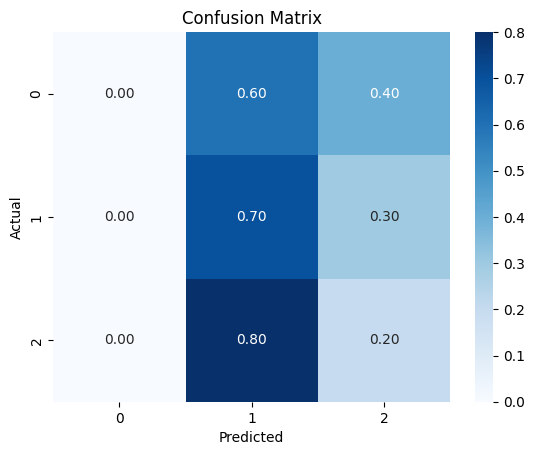

In [321]:
# training loop
import gc
gc.collect()
torch.cuda.empty_cache()

from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import WandbLogger,TensorBoardLogger
from lightning.pytorch.profilers import AdvancedProfiler

for x in ExperimentModel.existingModels:
    logDirectory = f"./lightning_logs/{x.__class__.__name__}"
    versionList = os.listdir(logDirectory)
    versionList.sort(key=lambda x: int(re.search(r'\d+', x).group()))
    print(x.__class__.__name__)
    gc.collect()
    torch.cuda.empty_cache()
    early_stopping = EarlyStopping(
        monitor='val_acc_F1',  # Metric to monitor
        patience=5,          # Number of epochs with no improvement after which training will be stopped
        verbose=False,        # Verbosity mode
        mode='min'           # Mode can be 'min', 'max', or 'auto'
    )

    checkpoint_callback = ModelCheckpoint(dirpath="my/path/", save_top_k=2, monitor="val_acc_F1")

    profiler = AdvancedProfiler(dirpath="./lightning_logs", filename="profiler_logs")
    
    tbLogger = TensorBoardLogger("lightning_logs",name=f"{x.__class__.__name__}")
    wandb_logger = WandbLogger(project=f"{x.__class__.__name__}",name=f"{x.__class__.__name__}")

    trainer = L.Trainer(
                        profiler = profiler,
                        max_epochs = 50,
                        min_epochs = 25,
                        accelerator ='gpu', 
                        devices = 'auto', 
                        precision = '16-mixed',
                        logger = tbLogger,
                        callbacks = [early_stopping,checkpoint_callback],
                    )
    
    trainer.fit(model=x,train_dataloaders=trainLoader,val_dataloaders=valLoader)


# GradCam Visualization

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.19.0', 'resnet50', pretrained=True)
resnetPath = r'C:\Users\assaw\Documents\c_stuff\Python\machine learning\ISAIConference\tb_logs\ResnetModel\version_22\checkpoints'
resnet50 = ResnetModel.load_from_checkpoint('\\'.join([resnetPath,os.listdir(resnetPath)[-1]]),resnet = model)
torch.cuda.empty_cache()
resnet50.to(device = torch.device('cuda'))
# out,label = resnet50.visualize(valLoader)
resnet50.on_validation_epoch_end()

In [ ]:
torch.cuda.empty_cache()
model = VGGModel.load_from_checkpoint(r'tb_logs\VGGModel\version_26\checkpoints\epoch=19-step=720.ckpt',vgg = torchvision.models.vgg19(pretrained=False))
outvgg,path = model.visualize(valLoader)

plt.imshow(outvgg[0])

# Classic pytorch for debugging

In [ ]:
model = resnet50

import torch
import torch.nn as nn
import torch.optim as optim
torch.cuda.empty_cache()
# Define the loss function
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.204, 0.052, 0.175],device='cuda'))

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the device to GPU if available
device = torch.device("cuda")

# Move the model to the device
model = model.to(device)

# Set the model to training mode
model.train()

num_epochs = 25

accHistory = []
lossHistory = []
valAccHistory = []
valLabs = []
valPreds = []
print("Starting training...")

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = []
    
    # Iterate over the training dataset
    for inputs, labels, _ in trainLoader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs.float())
        predicted_labels = torch.argmax(outputs, dim=1)
        accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)
        running_accuracy.append(accuracy)
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Print the average loss for the epoch
    print(f"Epoch {epoch+1} - Loss: {running_loss / len(trainLoader)}")
    print(F"Accuracy: {sum(running_accuracy)/len(running_accuracy)}")
    accHistory.append(sum(running_accuracy)/len(running_accuracy))
    lossHistory.append(running_loss / len(trainLoader))

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        
        runningValAccHistory = []
        runningValLabs = []
        runningValPreds = []
        for inputs, labels, _ in valLoader:

            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs.float())

            # Compute the loss
            loss = criterion(outputs, labels)

            # Compute the predicted labels
            predicted_labels = torch.argmax(outputs, dim=1)

            # Compute the accuracy
            accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)

            runningValAccHistory.append(accuracy)
            runningValLabs.append(labels)
            runningValPreds.append(predicted_labels)

        # print(f"Validation Loss: {loss.item()}")
        valPreds.append(runningValPreds)
        valLabs.append(runningValLabs)
        print(f"Validation Accuracy: {sum(runningValAccHistory)/len(valLoader)}")
        valAccHistory.append(sum(runningValAccHistory)/len(valLoader))

In [ ]:
import seaborn as sns
idx = 25
predsTest = torch.cat(valPreds[idx-1])
labelsTest = torch.cat(valLabs[idx-1])
print(valAccHistory[idx-1])
print(classification_report(predsTest.cpu(),labelsTest.cpu()))
cm= confusion_matrix(predsTest.cpu(),labelsTest.cpu(),normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

# Create a dataframe with the data
df = pd.DataFrame({'Epoch': range(len(accHistory)), 'Accuracy': accHistory, 'Loss': lossHistory, 'Validation Accuracy': valAccHistory})

# Create the line plot
sns.relplot(data=df, x='Epoch', y='Accuracy', kind='line')
sns.relplot(data=df, x='Epoch', y='Loss', kind='line')
sns.relplot(data=df, x='Epoch', y='Validation Accuracy', kind='line')